# Lung Cancer Histopathological image classification using VGG16 model

## Importing Data and libraries

In [26]:
# Importing libraries

import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, roc_auc_score, cohen_kappa_score, precision_score, recall_score, accuracy_score, confusion_matrix
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.models import Sequential
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.layers.normalization import BatchNormalization
from keras.models import Model, Sequential
from keras.applications.xception import Xception
from keras.applications import *
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from PIL import Image
import random
import os
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier 
from keras.callbacks import EarlyStopping
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from sklearn.decomposition import PCA
import matplotlib.image as mpimg



## Data preprocessing

In [30]:
data_dir = "E:/DataScience/archive/lung_colon_image_set/lung_image_sets"
SIZE_X = SIZE_Y = 128

datagen = tf.keras.preprocessing.image.ImageDataGenerator(validation_split = 0.3)

train_it = datagen.flow_from_directory(data_dir,
                                       class_mode = "categorical",
                                       target_size = (SIZE_X,SIZE_Y),
                                       color_mode="rgb",
                                       batch_size = 12, 
                                       shuffle = False,
                                       subset='training',
                                       seed = 42)

validate_it = datagen.flow_from_directory(data_dir,
                                       class_mode = "categorical",
                                       target_size = (SIZE_X, SIZE_Y),
                                       color_mode="rgb",
                                       batch_size = 12, 
                                       shuffle = False,
                                       subset='validation',
                                       seed = 42)

Found 10500 images belonging to 3 classes.
Found 4500 images belonging to 3 classes.


## Classes

In [31]:
train_it.class_indices

{'lung_aca': 0, 'lung_n': 1, 'lung_scc': 2}

In [32]:
def get_features(base_model, train, validate):
    X_train = base_model.predict(train)
    y_train = train.classes

    X_val = base_model.predict(validate)
    y_val = validate.classes

    X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size = 0.5, shuffle = True)
    print('Shape of X_train----->', str(X_train.shape))
    print('Shape of X_val----->', str(X_val.shape))
    print('Shape of X_test----->', str(X_test.shape))
    return (X_train, X_val, X_test, y_train, y_val, y_test)

## Build the Model

In [33]:
def get_models():
    ANN = Sequential()
    ANN.add(Dense(128, input_dim = X_train.shape[1], activation = 'relu'))
    ANN.add(BatchNormalization())
    ANN.add(Dropout(0.2))
    ANN.add(Dense(64, activation='relu'))
    ANN.add(Dense(32, activation='relu'))
    ANN.add(Dense(16, activation='relu'))
    ANN.add(Dense(8, activation='relu'))
    ANN.add(Dense(len(train_it.class_indices), activation='softmax'))
    ANN.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    KNN = KNeighborsClassifier()
    
    SVM = SVC(kernel = 'linear')
    
    RF = RandomForestClassifier(n_estimators = 50)
    
    ADB = AdaBoostClassifier()
    
    XGB = XGBClassifier(n_estimators = 50, use_label_encoder=False)
    
    print("Defined------->")
    print("ANN -------->", "(128x64x32x16x8)")
    print("KNeighborsClassifier()")
    print("SVC(kernel = 'linear')")
    print("RandomForestClassifier(n_estimators = 50)")
    print("AdaBoostClassifier()")
    print("XGBClassifier(n_estimators = 50)")
    
    return (ANN, KNN, SVM, RF, ADB, XGB)

## Data Reshape

In [34]:
def reshape_data(X_train, X_val, X_test):
    X_train = X_train.reshape(X_train.shape[0], -1)
    X_val = X_val.reshape(X_val.shape[0], -1)
    X_test = X_test.reshape(X_test.shape[0], -1)

    print("Shape after reshaping------->")
    print("X train------->", str(X_train.shape))
    print("X val-------->", str(X_val.shape))
    print("X test-------->", str(X_test.shape))
    
    return (X_train, X_val, X_test)

## Training The Model

In [35]:
def fit_ANN(model, X_train, y_train, X_val, y_test):
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    history = model.fit(X_train, y_train, validation_data=(X_val, y_test), epochs=10, verbose=1, callbacks=[es])
    
    accuracy = history.history['accuracy']
    val_accuracy =history.history['val_accuracy']
    loss = history.history['loss']
    val_loss =history.history['val_loss']
    
    #accuarcy and loss
    epochs = range(len(accuracy))
    plt.plot(epochs, accuracy, 'r-', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'r-', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()
    
    return model

def fit_model(model, X_train, y_train):
    model.fit(X_train, y_train)
    return model

def get_accuracy_metrics_for_ANN(model, X_train, y_train, X_val, y_val, X_test, y_test):
    print("Train accuracy Score------------>")
    print ("{0:.3f}".format(accuracy_score(y_train, np.argmax(model.predict(X_train), axis = 1))*100), "%")
    
    print("Val accuracy Score--------->")
    val_pred = np.argmax(model.predict(X_val), axis = 1)
    print("{0:.3f}".format(accuracy_score(y_val, val_pred)*100), "%")
    
    predicted =  np.argmax(model.predict(X_test), axis = 1)
    print("Test accuracy Score--------->")
    print("{0:.3f}".format(accuracy_score(y_test, predicted)*100), "%")
    
    print("F1 Score--------------->")
    print("{0:.3f}".format(f1_score(y_test, predicted, average = 'weighted')*100), "%")
    
    print("Cohen Kappa Score------------->")
    print("{0:.3f}".format(cohen_kappa_score(y_test, predicted)*100), "%")
    
    print("Recall-------------->")
    print("{0:.3f}".format(recall_score(y_test, predicted, average = 'weighted')*100), "%")
    
    print("Precision-------------->")
    print("{0:.3f}".format(precision_score(y_test, predicted, average = 'weighted')*100), "%")
    
    cf_matrix_test = confusion_matrix(y_test, predicted)
    cf_matrix_val = confusion_matrix(y_val, val_pred)
    
    plt.figure(figsize = (12, 6))
    plt.subplot(121)
    sns.heatmap(cf_matrix_val, annot=True, cmap='Blues')
    plt.title("Val Confusion matrix")
    
    plt.subplot(122)
    sns.heatmap(cf_matrix_test, annot=True, cmap='Blues')
    plt.title("Test Confusion matrix")
    
    plt.show()

## KNN with PCA Technique

In [36]:
def fit_KNN_metrics(model, X_train, y_train, X_val, y_val, X_test, y_test):

    pca = PCA(n_components=1000)
    randlist = random.sample(range(0, X_train.shape[0]), 600)
    if(X_train.shape[1] > 1000):
        X_train = pca.fit_transform(X_train)
        X_val = pca.transform(X_val)
        X_test = pca.transform(X_test)

    model.fit(X_train, y_train)
    get_accuracy_metrics(model, X_train[randlist, :], y_train[randlist], X_val, y_val, X_test, y_test)
    
def get_accuracy_metrics(model, X_train, y_train, X_val, y_val, X_test, y_test):
    print("Train accuracy Score------------>")
    print ("{0:.3f}".format(accuracy_score(y_train, model.predict(X_train))*100), "%")
    
    print("Val accuracy Score--------->")
    val_pred = model.predict(X_val)
    print("{0:.3f}".format(accuracy_score(y_val, val_pred)*100), "%")
    
    predicted =  model.predict(X_test)
    print("Test accuracy Score--------->")
    print("{0:.3f}".format(accuracy_score(y_test, predicted)*100), "%")
    
    print("F1 Score--------------->")
    print("{0:.3f}".format(f1_score(y_test, predicted, average = 'weighted')*100), "%")
    
    print("Cohen Kappa Score------------->")
    print("{0:.3f}".format(cohen_kappa_score(y_test, predicted)*100), "%")
    
    print("Recall-------------->")
    print("{0:.3f}".format(recall_score(y_test, predicted, average = 'weighted')*100), "%")
    
    print("Precision-------------->")
    print("{0:.3f}".format(precision_score(y_test, predicted, average = 'weighted')*100), "%")

#     cf_matrix_test = confusion_matrix(y_test, predicted)
#     cf_matrix_val = confusion_matrix(y_val, val_pred)
    
#     plt.figure(figsize = (12, 6))
#     plt.subplot(121)
#     sns.heatmap(cf_matrix_val, annot=True, cmap='Blues')
#     plt.title("Val Confusion matrix")
    
#     plt.subplot(122)
#     sns.heatmap(cf_matrix_test, annot=True, cmap='Blues')
#     plt.title("Test Confusion matrix")
    
    plt.show()

## VGG16 Model

In [37]:
base_model = VGG16(include_top=False, input_shape=(SIZE_X, SIZE_Y, 3), weights='imagenet')

for layer in base_model.layers:
    layer.trainable = False
                   
model = Model(inputs=base_model.input, outputs=base_model.layers[-1].output)
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0   

In [38]:
##Split the data to test,train and validate
X_train, X_val, X_test, y_train, y_val, y_test = get_features(model, train_it, validate_it)

Shape of X_train-----> (10500, 4, 4, 512)
Shape of X_val-----> (2250, 4, 4, 512)
Shape of X_test-----> (2250, 4, 4, 512)


In [39]:
##Train and get features for all the classifiers
X_train, X_val, X_test = reshape_data(X_train, X_val, X_test)
ANN, KNN, SVM, RF, ADB, XGB = get_models()

ANN = fit_ANN(ANN, X_train, y_train, X_val, y_val)

Shape after reshaping------->
X train-------> (10500, 8192)
X val--------> (2250, 8192)
X test--------> (2250, 8192)
Defined------->
ANN --------> (128x64x32x16x8)
KNeighborsClassifier()
SVC(kernel = 'linear')
RandomForestClassifier(n_estimators = 50)
AdaBoostClassifier()
XGBClassifier(n_estimators = 50)
Epoch 1/10
329/329 [==============================] - 2s 5ms/step - loss: 0.5362 - accuracy: 0.6797 - val_loss: 0.0941 - val_accuracy: 0.9538
Epoch 2/10
329/329 [==============================] - 2s 5ms/step - loss: 0.0949 - accuracy: 0.9646 - val_loss: 0.0572 - val_accuracy: 0.9773
Epoch 3/10
329/329 [==============================] - 1s 5ms/step - loss: 0.0535 - accuracy: 0.9810 - val_loss: 0.2290 - val_accuracy: 0.9178
Epoch 4/10
329/329 [==============================] - 1s 4ms/step - loss: 0.0496 - accuracy: 0.9816 - val_loss: 0.0774 - val_accuracy: 0.9667
Epoch 5/10
329/329 [==============================] - 1s 5ms/step - loss: 0.0325 - accuracy: 0.9889 - val_loss: 0.0458 - val_a

Train accuracy Score------------>
99.848 %
Val accuracy Score--------->
98.400 %
Test accuracy Score--------->
97.600 %
F1 Score--------------->
97.600 %
Cohen Kappa Score------------->
96.399 %
Recall-------------->
97.600 %
Precision-------------->
97.622 %


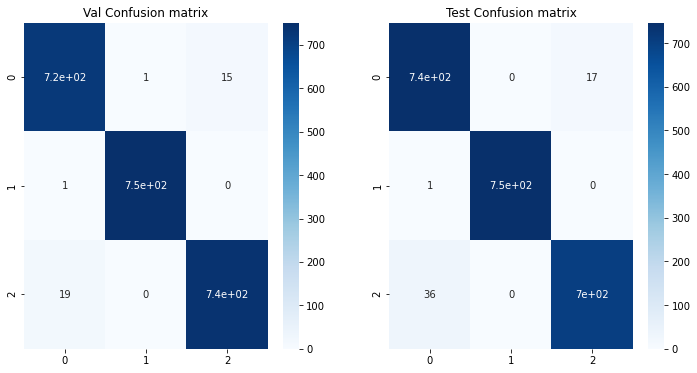

In [40]:
## To calculate the Accuracy for ANN
get_accuracy_metrics_for_ANN(ANN, X_train, y_train, X_val, y_val, X_test, y_test)

Train accuracy Score------------>
92.800 %
Val accuracy Score--------->
88.578 %
Test accuracy Score--------->
86.889 %
F1 Score--------------->
86.517 %
Cohen Kappa Score------------->
80.361 %
Recall-------------->
86.889 %
Precision-------------->
88.749 %


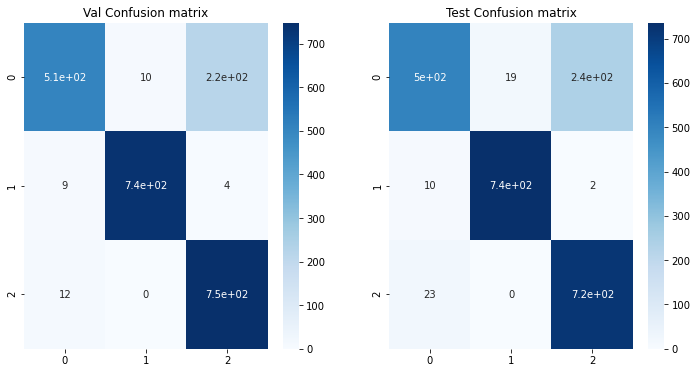

In [41]:
## To scale the train ,train and validate dataset
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

fit_KNN_metrics(KNN, X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test)

Train accuracy Score------------>
100.000 %
Val accuracy Score--------->
97.867 %
Test accuracy Score--------->
97.422 %
F1 Score--------------->
97.422 %
Cohen Kappa Score------------->
96.133 %
Recall-------------->
97.422 %
Precision-------------->
97.425 %


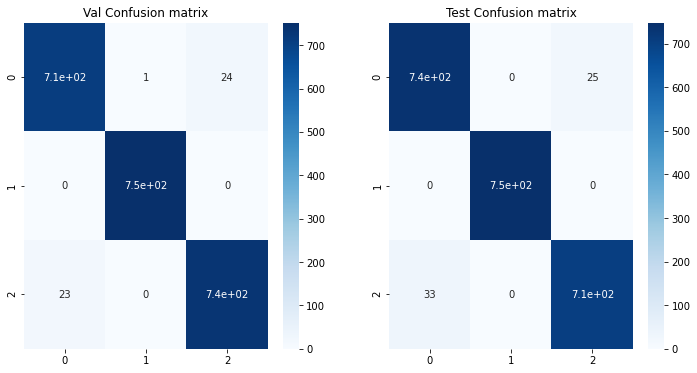

In [42]:
##To train and get accuarcy for SVM classifier
SVM = fit_model(SVM, X_train_scaled, y_train)
get_accuracy_metrics(SVM, X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test)

Train accuracy Score------------>
100.000 %
Val accuracy Score--------->
95.822 %
Test accuracy Score--------->
95.467 %
F1 Score--------------->
95.461 %
Cohen Kappa Score------------->
93.198 %
Recall-------------->
95.467 %
Precision-------------->
95.504 %


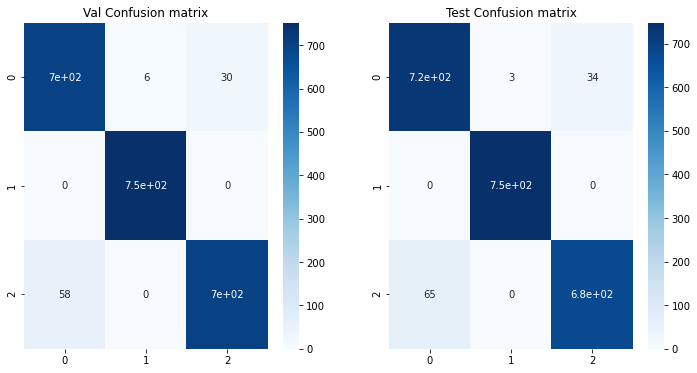

In [43]:
##To train and get accuarcy for RF classifier
RF = fit_model(RF, X_train, y_train)
get_accuracy_metrics(RF,  X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test)

Train accuracy Score------------>
90.467 %
Val accuracy Score--------->
90.667 %
Test accuracy Score--------->
91.156 %
F1 Score--------------->
91.137 %
Cohen Kappa Score------------->
86.739 %
Recall-------------->
91.156 %
Precision-------------->
91.451 %


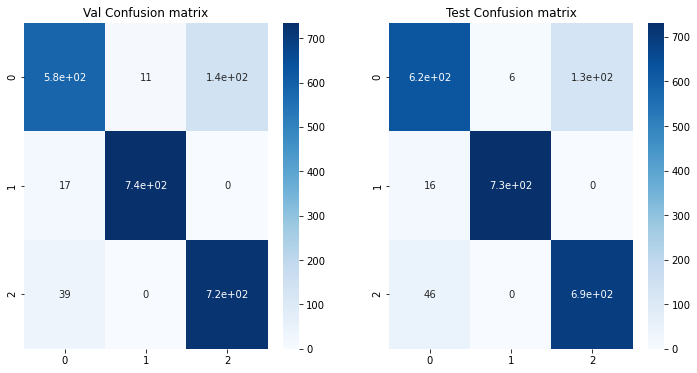

In [44]:
##To train and get accuarcy for Adaboost classifier
ADB = fit_model(ADB, X_train, y_train)
get_accuracy_metrics(ADB,  X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test)

[02:53:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train accuracy Score------------>
100.000 %
Val accuracy Score--------->
97.511 %
Test accuracy Score--------->
96.400 %
F1 Score--------------->
96.402 %
Cohen Kappa Score------------->
94.599 %
Recall-------------->
96.400 %
Precision-------------->
96.407 %


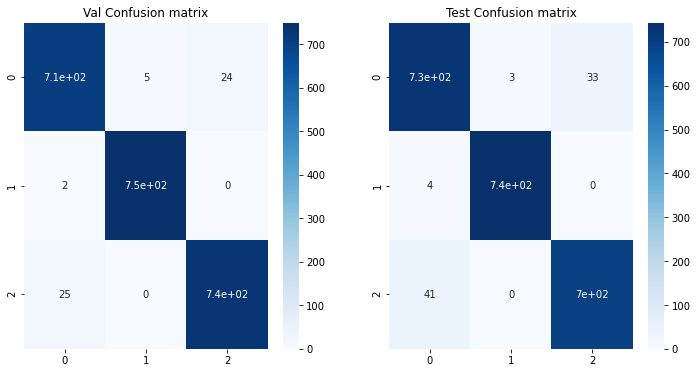

In [45]:
##To train and get accuarcy for XGBoost classifier
XGB = fit_model(XGB, X_train, y_train)
get_accuracy_metrics(XGB,  X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test)